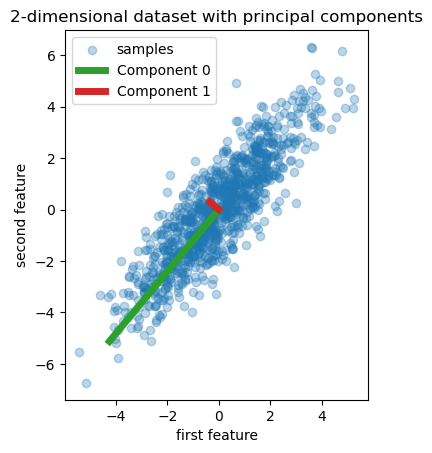

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

rng = np.random.RandomState(1)
n_samples = 1000
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
for i, (comp,var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

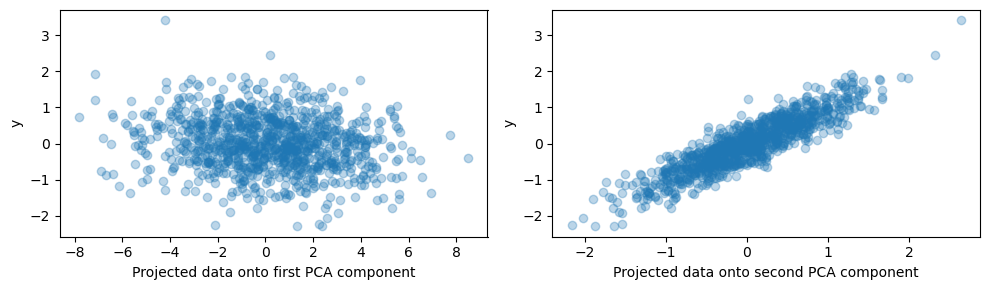

In [15]:
y = X.dot(pca.components_[1] + 0.1 * rng.randn(2)) + 0.3 * rng.randn(n_samples)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(X.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel="Projected data onto first PCA component",
            ylabel='y')
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel="Projected data onto second PCA component",
            ylabel='y')
fig.tight_layout()
plt.show()

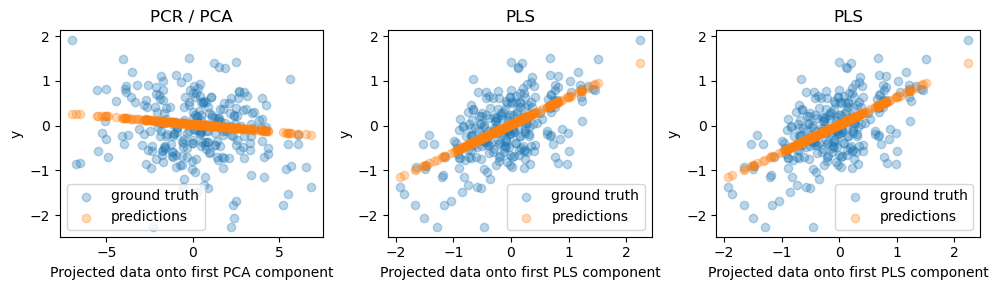

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PLSRegression import PLSRegression as PLSRegression_scratch
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

pca = pcr.named_steps['pca']  

pls1 = PLSRegression_scratch(n_components=1)
pls1.fit(X_train, y_train)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test)[:, 0], pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test)[:, 0], pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()

axes[2].scatter(pls1.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[2].scatter(pls1.transform(X_test)[:, 0], pls1.predict(X_test), alpha=.3,
                label='predictions')
axes[2].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[2].legend()

fig.tight_layout()
plt.show()